In [71]:
import os,sys
sys.path.append('./PTS')
from run_skirt8 import get_lightcurve
import numpy as np
from astropy import units as u
from astropy import constants as c
from scipy import optimize as opt
import datetime

import matplotlib.pyplot as plt
from utils import *
from astropy.time import TimeDelta 
from astropy.time import Time
from astropy.io import ascii
from opt_depth import *
from scipy.optimize import curve_fit
from scipy.integrate import quad
%matplotlib inline





tau = [20,23,26,29,32,35]
radius = [0.15,0.2,0.5,0.75,1.0,1.5,2.0,2.5]
radius_p = [3.0,3.5,4.0,4.5,5,7.5,10]
tot_R = radius + radius_p
print(tot_R)

total_R = radius+ radius_p
file_loc = '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839' #subject to change


total_luminosity = {}
for i in tau:
    total_luminosity[i]=np.genfromtxt(file_loc+str(f'/ChangingTau/tau={i}/luminosity_data.txt'),delimiter = ',')


[0.15, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5, 7.5, 10]


# Initial value

In [74]:
# Define Simulation Parameters

timesteps = 10          # amount of timesteps considered by SKIRT
output_tsteps = 100     # desired amount of timesteps after interpolation

amin = 0.005            # smallest dust grain size in micron, 1e-4 is the lowest value supported by SKIRT, 0.005 from paper with opacity
amax = 0.1              # largest dust grain size in micron
grainpowerlaw = 2.5     # the powerlaw distribution of mass along different grain sizes
alpha = 1               # radial dust mass density powerlaw

opt_depth = 25           # Optical depth of dust structure
axis = 'Z'              # Axis along which to measure the optical depth
wl_opt_depth = 0.28     # Wavelength along which to measure optical depth

Si = 0.                 # silicates fraction (as opposed to graphites)
Lbol_factor = 5         # bolometric correction factor

#for a thin shell we altered these values. 
centralBin = 0.1        # size of central grid section in pc
outer = 0.15           # outer radius of the dust shell in pc
spaceBins = 10          # number of spatial shells in the radial direction

#total_mass = (mass_from_opacity(centralBin,outer,10,10**(0.836))).value
#total_mass = mass_from_opt_depth(amax,centralBin,outer,opt_depth,find_cross_section('/data/DraineGrains/callqcomp.txt',wl_opt_depth,amax)).value # of the dust in MSun
target = 'ASASSN-15lh'
distance = 1171*u.Mpc
peak = 57250

lightcurve = True

today = str(datetime.date.today())
starttime = datetime.datetime.now().strftime('%H%M')

OUTFILES = "results/"+target+'/'+today+'_L'+'/'+starttime+'/'
PLOTFILES = "plots/"+target+'/'+today+'_L'+'/'+starttime+'/'
DATAFILES = "data_new/"+target+'/'

if os.path.isdir(DATAFILES) == False:
    os.makedirs(DATAFILES[:-1])
if os.path.isdir(OUTFILES) == False:
    os.makedirs(OUTFILES[:-1])
if os.path.isdir(PLOTFILES) == False:
    os.makedirs(PLOTFILES[:-1])
timesteps = 10          # amount of timesteps considered by SKIRT
output_tsteps = 100
log=open(OUTFILES+'log.txt','a')
_, _, _, mjd0 = get_lightcurve_data()
L = data_luminosity(tde_name = target, datafolder = 'data_new', distance=distance) #nu_Lnu of the data
WISE_data =ascii.read(DATAFILES+'ASASSN-15lh_neoWISE_diffphoto.dat',format='fixed_width')
W1 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w1_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w1_flux_Jy_err']*u.Jy,distance=distance)])
W2 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w2_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w2_flux_Jy_err']*u.Jy,distance=distance)])

color_data =ascii.read(DATAFILES+'ASASSN-15lh_neoWISE_diffphoto.dat',format='fixed_width')
color_error = np.sqrt(color_data['w1_mag_err']**2 + color_data['w2_mag_err']
                          ** 2 )#+ 2 * color_data['w1_mag_err']*color_data['w2_mag_err']
# Central wavelengths of the 2 WISE filters
wl_w1=3.368*u.um
wl_w2=4.618*u.um

#Sorting the data based on time
sorted_indices = L[0].argsort()

# Reduce the amount of timesteps to 'timesteps', with a number of them concentrated close to the peak
# if timesteps is increased, users might want to omit this
t_data=np.concatenate(([np.min(L[0]),np.sort(L[0])[1],np.sort(L[0])[2],np.min(L[0])+20],\
                       np.linspace(np.min(L[0])+40,np.max(L[0]),timesteps-3)))


L_data=binning(t_data,L[0],L[1],L[2])
t_data=L_data[0]

# We will use a constant temperature of 2e4 K here, 
# as our data set does not provide a very accurate read on the TDE's temperature evolution
T_data = np.array((L_data[0],[2e4]*len(L_data[2])))

output_t=np.linspace(np.min(t_data),np.max(np.concatenate([W1[0],W2[0]])),output_tsteps)



w1w2 = np.array([3.368,4.618])
bbwl = np.array([0.29*1e4/(2e4)]) #From Wiens law: wavelength at which the black body peaks
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 50), np.linspace(1.01, 10, 100), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))


relBinwidth = 0.0001  #Relative bin width for the wavelength bins.
#print([np.argmin(np.abs(output_t-59161.28061156))])

# Temperature_analysis

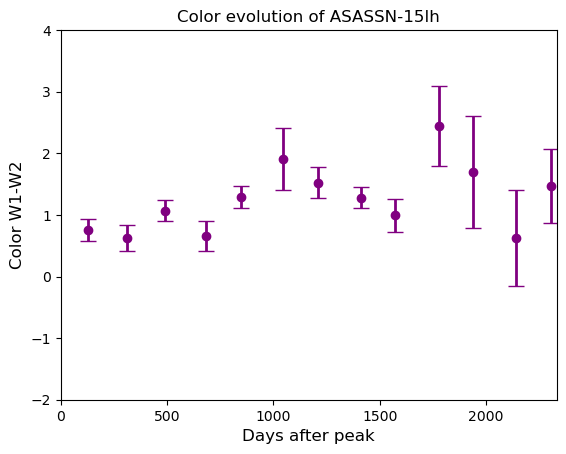

In [75]:

plt.errorbar(color_data['mjd']-mjd0, color_data['w1_vegamag'] - color_data['w2_vegamag'],color_error, fmt='o', linewidth=2, capsize=6,label=f'Color data {target}' , color='purple')
plt.ylim(-2,4)
plt.xlim(0,output_t[76])
plt.ylabel('Color W1-W2',fontsize = 12)
plt.xlabel('Days after peak',fontsize = 12)
plt.title('Color evolution of ASASSN-15lh')
plt.savefig('color_plot_asassn.pdf')



In [89]:
from scipy.stats import chisquare as chi
import numpy as np
import astropy.constants as c

unit_Lnu = u.erg/(u.Hz*u.s)
output_t=np.linspace(np.min(t_data),np.max(np.concatenate([W1[0],W2[0]])),output_tsteps)
output_wavelengths = np.genfromtxt('/net/vdesk/data2/Lankhorst/brp2/results/ASASSN-15lh/2024-05-30/2103/fitting/wavelengths.txt',delimiter=' ')
fit_1_loc = '/net/vdesk/data2/schoof/SKIRT/results/ASASSN-15lh/2024-05-30/2126/fitting/luminosity.txt'
fit_2_loc = '/net/vdesk/data2/Lankhorst/brp2/results/ASASSN-15lh/2024-05-30/2103/fitting//luminosity.txt'
fit_1 = np.genfromtxt(fit_1_loc,delimiter=' ')

fit_2 = np.genfromtxt(fit_2_loc,delimiter=' ')


w1w2 = np.array([3.368,4.618])
bbwl = np.array([0.29*1e4/(2e4)]) #From Wiens law: wavelength at which the black body peaks


l1 = lightcurve_transmission('WISE_W1', output_wavelengths,fit_1[1:76]*unit_Lnu)
l2 = lightcurve_transmission('WISE_W2', output_wavelengths,fit_2[1:76]*unit_Lnu)

coveringFactor=np.max(W1[1])/l1[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])]))]               

norm_fit_1 = coveringFactor*((c.c / wl_w1).to(u.Hz) * l1).to(u.erg / u.s).to(u.erg / u.s)
W1_data = (c.c/wl_w1).to(u.Hz).value*W1[1]
#chi(norm_fit_1 ,W1_data )







norm_fit_2 = coveringFactor*((c.c / wl_w1).to(u.Hz) * l2).to(u.erg / u.s).to(u.erg / u.s)

import numpy as np
import scipy.stats as stats
from astropy import units as u
import astropy.constants as c

# Your setup for unit_Lnu and other necessary variables
unit_Lnu = u.erg / (u.Hz * u.s)

# Define your observed data (W1 and W2)
# Assuming W1[0] and W1[1] are your time and data arrays respectively

# Interpolating or matching the length of output_t and W1[0]
# Assuming output_t, W1[0], and W1[1] are already defined and loaded properly

# Check shapes
print(f"Shape of output_t: {output_t.shape}")
print(f"Shape of W1[0]: {W1[0].shape}")
print(f"Shape of W1[1]: {W1[1].shape}")

# Assuming wl_w1 is the wavelength for W1
# Calculate norm_fit_1 and norm_fit_2
coveringFactor = np.max(W1[1]) / l1[np.argmin(np.abs(output_t - W1[0, np.argmax(W1[1])]))]

# Ensure matching lengths
W1_interp = np.interp(output_t, W1[0], W1[1])
print(f"Shape of W1_interp: {W1_interp.shape}")

# Interpolate l1 to output_t
l1_interp = np.interp(output_t, output_t[:len(l1)], l1)
norm_fit_1 = coveringFactor * ((c.c / wl_w1).to(u.Hz) * l1_interp).to(u.erg / u.s).value
print(f"Shape of norm_fit_1: {norm_fit_1.shape}")

# Make sure W1_data is consistent
W1_data = (c.c / wl_w1).to(u.Hz).value * W1_interp
print(f"Shape of W1_data: {W1_data.shape}")

# Normalize norm_fit_1 to match the sum of W1_data
norm_fit_1 *= np.sum(W1_data) / np.sum(norm_fit_1)

# Chi-square test
chi_square_fit1, p_value_fit1 = stats.chisquare(f_obs=W1_data, f_exp=norm_fit_1.value)

# Print results
print(f"Chi-square statistic for Fit 1: {chi_square_fit1}")
print(f"P-value for Fit 1: {p_value_fit1}")

# Similarly, adjust for Fit 2
l2_interp = np.interp(output_t, output_t[:len(l2)], l2)
norm_fit_2 = coveringFactor * ((c.c / wl_w1).to(u.Hz) * l2_interp).to(u.erg / u.s).value

# Normalize norm_fit_2 to match the sum of W1_data
norm_fit_2 *= np.sum(W1_data) / np.sum(norm_fit_2)

chi_square_fit2, p_value_fit2 = stats.chisquare(f_obs=W1_data, f_exp=norm_fit_2)

# Print results for Fit 2
print(f"Chi-square statistic for Fit 2: {chi_square_fit2}")
print(f"P-value for Fit 2: {p_value_fit2}")



Shape of output_t: (100,)
Shape of W1[0]: (20,)
Shape of W1[1]: (20,)
Shape of W1_interp: (100,)
Shape of norm_fit_1: (100,)
Shape of W1_data: (100,)
Chi-square statistic for Fit 1: 2.1856125077557345e+44
P-value for Fit 1: 0.0
Chi-square statistic for Fit 2: 2.3845893500812036e+44
P-value for Fit 2: 0.0


In [92]:
# -*- coding: utf-8 -*-


from scipy.signal import savgol_filter
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as colors
from utils import *
from astropy.io import ascii
import json
class data_analysis():

    target = 'ASASSN-15lh'
    today = str(datetime.date.today())
    starttime = datetime.datetime.now().strftime('%H%M')
    PLOTFILES = "plots/"+target+'/'+today+'_L'+'/'+starttime+'/'
    if os.path.isdir(PLOTFILES) == False:
        os.makedirs(PLOTFILES[:-1])
    timesteps = 10          # amount of timesteps considered by SKIRT
    output_tsteps = 100
    log=open(OUTFILES+'log.txt','a')
    _, _, _, mjd0 = get_lightcurve_data()
    L = data_luminosity(tde_name = target, datafolder = 'data_new', distance=distance) #nu_Lnu of the data
    WISE_data =ascii.read(DATAFILES+'ASASSN-15lh_neoWISE_diffphoto.dat',format='fixed_width')
    W1 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w1_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w1_flux_Jy_err']*u.Jy,distance=distance)])
    W2 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w2_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w2_flux_Jy_err']*u.Jy,distance=distance)])
    
    color_data =ascii.read(DATAFILES+'ASASSN-15lh_neoWISE_diffphoto.dat',format='fixed_width')
    color_error = np.sqrt(color_data['w1_mag_err']**2 + color_data['w2_mag_err']
                              ** 2 )#+ 2 * color_data['w1_mag_err']*color_data['w2_mag_err']
    # Central wavelengths of the 2 WISE filters
    wl_w1=3.368*u.um
    wl_w2=4.618*u.um
    
    #Sorting the data based on time
    sorted_indices = L[0].argsort()
    
    # Reduce the amount of timesteps to 'timesteps', with a number of them concentrated close to the peak
    # if timesteps is increased, users might want to omit this
    t_data=np.concatenate(([np.min(L[0]),np.sort(L[0])[1],np.sort(L[0])[2],np.min(L[0])+20],\
                           np.linspace(np.min(L[0])+40,np.max(L[0]),timesteps-3)))
    
    
    L_data=binning(t_data,L[0],L[1],L[2])
    t_data=L_data[0]
    
    # We will use a constant temperature of 2e4 K here, 
    # as our data set does not provide a very accurate read on the TDE's temperature evolution
    T_data = np.array((L_data[0],[2e4]*len(L_data[2])))
    
    output_t=np.linspace(np.min(t_data),np.max(t_data)+0.3*(np.max(t_data)-np.min(t_data)),output_tsteps)
        
    

    bbwl = np.array([0.29*1e4/(2e4)])
    

    # OUTput_wave needs to be added !!!
    # xrange
    def __init__(self, file_loc, parameter_variation=None, unit='', parameter='', data_end=73, 
                 output_wavelengths=np.sort(np.concatenate((np.linspace(0.01, 1, 50), np.linspace(1.01, 10, 100),np.linspace(10.01, 50, 100), w1w2, bbwl))),
                 x_range=np.linspace(output_wavelengths[0], output_wavelengths[-1], 2000), low_photon = False, set_par_name = None,
                 R_inner = 0.1,color_map = 'cubehelix'):
        """
        file_loc: (str) the location of the data.
        parameter_variation: (list) variation on the given parameter.
        unit: (str) unit of the parameter.
        parameter:(str) name of the parameter, i.e. R for radius.
        data_end: (int) makes sure that the only the simulated data is used for which we posess actual data. 
        output_wavelengths: (np.array) the wavelengths for which the spectra will be made. 
        x_range:(np.array) the x domain for the blackbody fit.
        low_photon: (bool) will smoothen the data if turned on.
        set_par_name: (str) will change the parameter name to this, useful for making plots with latex code. i.e. tau -> $\tau$.
        R_inner: (float) is the distance to the dust shell, will be taken into account when varying the thickness 
        
        """
        
        self.parameter_variation = parameter_variation
        self.unit = unit
        self.parameter = parameter
        self.data_end = data_end
        self.x_range = x_range
        self.output_wavelengths = output_wavelengths
        self.output_t = np.linspace(np.min(t_data),np.max(t_data)+0.3*(np.max(t_data)-np.min(t_data)),output_tsteps)
        self.set_par_name = set_par_name
        
        
        self.cmap = plt.get_cmap(color_map)
        
        if self.parameter_variation is not None: #data collection for varitation run
            self.single = False 
            self.luminosity_data = {}
            for i in self.parameter_variation: 
                
                self.luminosity_data[i] = np.genfromtxt(
                    file_loc + str(f'/{self.parameter}={i}/luminosity_data.txt'), delimiter=' ') 
                
                if low_photon: #smoothing the data if necessary
                    
                    self.luminosity_data[i][12] = savgol_filter(self.luminosity_data[i][12], window_length=30, polyorder=2)
                    
                    
                        
            if self.set_par_name  is not None: #chaning the parameter name 
                self.parameter = self.set_par_name 
            
        else:
            # needs to change still
            self.luminosity_data = np.genfromtxt(
                file_loc + str('config.txt'), delimiter=' ')
            self.single = True

        
        self.w1s = []
        self.w2s = []
        
        wl_w1=3.368*u.um
        wl_w2=4.618*u.um
        
        
        for i in range(len(self.luminosity_data[self.parameter_variation[0]])):
            # Indices corresponding to the WISE filter and black body peak wavelengths
            self.w1s.append(np.argmin(np.abs(self.output_wavelengths[i]-wl_w1.value)))
            self.w2s.append(np.argmin(np.abs(self.output_wavelengths[i]-wl_w2.value)))

        if self.parameter == 'thickness': #when simulating the thickness we need to subtract the distance to the dust shell. 
            old_parameter_variation = self.parameter_variation
            self.parameter_variation = np.round([R_outer - R_inner for R_outer in self.parameter_variation],2)
            for i in range(len(self.parameter_variation)):#data will be renamed
                self.luminosity_data[self.parameter_variation[i]] = self.luminosity_data[old_parameter_variation[i]]
    
    
    def debug(self): #for debugging purposes. 
        # print(self.luminosity_data)
        _, _, _, mjd0 = get_lightcurve_data()
        normal_time=output_t
        print(normal_time)

    def __call__(self):
        self.plot()
        self.temperature()
        self.color()

    def spectra(self,multi_plot=False, all_spectra = False,time=12, save=False, fit_value=None, fit=True, plot_title = None,thesis_plot=False,spectra_evolution= False):
        """
        

        Parameters
        ----------
        all_spectra : TYPE, optional
            Will show all spectra available if turned to true. The default is False.
        time : TYPE, optional
            Is the number of the spectra you are going to show. The default is 12 this equates to roughly 300 days after peak.
        save : TYPE, optional
            Will create a save of the plots. The default is False.
        fit_value : TYPE, optional
            The value of the parameter of which you want to fit a black body fucntion on its spectra. The default is None, this will make the fit on self.parameter_variation[0].
        fit : TYPE, optional
            Turns on/off the fitting function. The default is True.

        Returns
        -------
        None.

        """
            
        _, _, _, mjd0 = get_lightcurve_data()
        target = 'ASASSN-15lh'
        today = str(datetime.date.today())
        starttime = datetime.datetime.now().strftime('%H%M')
        if thesis_plot:
            PLOTFILES = 'thesis_plot/'+target+'/'+self.parameter+'/'+'without_target/'
            if spectra_evolution:
                PLOTFILES = 'thesis_plot/'+target+'/'+'Spectra_evolution/'+self.parameter+'/'
                
            
    
        else:
            PLOTFILES = "plots/"+target+'/'+today+'_L'+'/'+starttime+'/'
        if os.path.isdir(PLOTFILES) == False:
            os.makedirs(PLOTFILES[:-1])
        cmap = self.cmap
        normal_time=self.output_t
        if self.single:
            max_y = np.max(self.luminosity_data)*1.2
            lower_y = max_y/(1e5)
            if all_spectra:
                p = 0
                
                for i in range(1,self.data_end):
                    color = cmap(p/len(range(1, self.data_end)))
                    plt.loglog(self.output_wavelengths,self.luminosity_data[i,:],color = color)
                    p+=1
                
                plt.xlabel('Wavelength [$\mu$m]')    
                plt.ylabel(r'  $L_{\nu}$ [erg/s/Hz]')
                plt.title('All spectra.')
                plt.ylim(lower_y, max_y*1.05)
                plt.xlim(0.3)
                if save:
                    plt.savefig(PLOTFILES+f'All_spectra.jpeg', bbox_inches='tight')
                    print(f'Saving figure to {PLOTFILES}')
                    plt.close()
                plt.show()
                
            
        
            plt.loglog(self.output_wavelengths,
                       self.luminosity_data[time, :], label=f'Spectra')
            if fit:
                self.fit()
            plt.title(
                f'Spectra taken on {np.round(normal_time[time])} days after peak')
            

        else: #----------------Multiple parameters---------------
            
            lines = []
            if fit_value == None:
                fit_value = self.parameter_variation[0]
            p = 0
            for i in self.parameter_variation:
                color = cmap(p/len(self.parameter_variation))
                plt.loglog(self.output_wavelengths, self.luminosity_data[i][time, :],
                           label=f'{self.parameter} = {i} {self.unit}', color=color)
                line = plt.loglog(self.output_wavelengths, self.luminosity_data[i][time, :],
                           label=f'{self.parameter} = {i} {self.unit}', color=color)
                lines.append(line)
                p += 1
                if fit:
                    if i == fit_value:
                        self.fit(fit_value = fit_value,time=time)
            #plt.axvline(x=3.368,color = 'black',label = 'W1',alpha = 0.6,linestyle = '--')
            max_y =  np.max(list(self.luminosity_data.values()))*1.2
            
            lower_y = max_y/(1e5)
            
            if plot_title is None:
                plot_title = f'Spectra with various {self.parameter} taken {np.round(normal_time[time])} days after peak'
            plt.title(plot_title)

            plt.ylim(lower_y, max_y*1.05)
            plt.xlim(0.3,np.max(self.output_wavelengths))
            plt.xlabel('Wavelength [$\mu$m]')    
            plt.ylabel(r'  $L_{\nu}$ [erg/s/Hz]')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
            if save:
                
                print(f'Saving figure to {PLOTFILES}')
                if spectra_evolution:
                    plt.savefig(PLOTFILES+f'Spectra_{self.parameter}_time={np.round(normal_time[time])}.pdf', bbox_inches='tight')  
                else:
                    plt.savefig(PLOTFILES+f'Spectra_{self.parameter}.pdf', bbox_inches='tight')
    
                #plt.close()
            plt.show()
            if multi_plot:
                return lines

    def temperature(self,color_value = None, save= False,table =False,show_target = True, target = 'ASASSN-15lh',plot_title = None,thesis_plot = False):
        """
        

        Parameters
        ----------
        color_value : TYPE, optional
            Value of the parameter of which you want to create the color evolution. The default is None which takes self.parameter_variation[0].
        save : TYPE, optional
            Will create a save of the plots. The default is False.
        table : TYPE, optional
            Creates latex code you can copy directly into overleaf for example. The default is False.
        plot_title: 
            Sets the title of the plot. 

        Returns
        -------
        None.

        """
        _, _, _, mjd0 = get_lightcurve_data()
        T_list = []
        T_wien = []
        time = []
        cmap = self.cmap
        
        w1 = np.argmin(np.abs(self.output_wavelengths-wl_w1.value))
        w2 = np.argmin(np.abs(self.output_wavelengths-wl_w2.value))
        
        
        DATAFILES = "data_new/"+target+'/'
        color_data = ascii.read(
        DATAFILES+target+'_neoWISE_diffphoto.dat', format='fixed_width')
        
        today = str(datetime.date.today())
        starttime = datetime.datetime.now().strftime('%H%M')
        if thesis_plot:
            if show_target:
                PLOTFILES = 'thesis_plot/'+target+'/'+self.parameter+'/'
            else:
                PLOTFILES = 'thesis_plot/'+target+'/'+self.parameter+'/'+'without_target/'
            
            
    
        else:
            PLOTFILES = "plots/"+target+'/'+today+'_L'+'/'+starttime+'/'
        if os.path.isdir(PLOTFILES) == False:
            os.makedirs(PLOTFILES[:-1])
        color_error = np.sqrt(color_data['w1_mag_err']**2 + color_data['w2_mag_err']
                          ** 2 )#+ 2 * color_data['w1_mag_err']*color_data['w2_mag_err']
        normal_time=self.output_t
        if self.single:
            for i in range(1,self.data_end):
                T_list.append(self.fit(time = i, plot=False))
                time.append(normal_time[i])
            T = np.round(np.average(T_list))
            print(f'The average temperature for this spectra is {T} K')
            return

        
        else:
            if color_value == None:
                color_value = self.parameter_variation[0]
            fig, ax1 = plt.subplots(layout='constrained')
            p = 0
            data_array = []
            header = [f'{self.parameter} {self.unit}','Average temperature [K]']
            
            for i in self.parameter_variation:
                T_list = []
                time = []
                color = cmap(p/len(self.parameter_variation))
                for j in range(1,self.data_end):
                    T_list.append(self.fit(time = j,plot=False,fit_value = i))
                    time.append(normal_time[j])
                T = np.round(np.average(T_list))
                data_array.append([i, T])
                print(f'The average temperature for this spectra with {self.parameter} = {i} {self.unit} is {T} K')
                
                ax1.plot(time,T_list,label = f'{self.parameter} = {i} {self.unit}',color=color)
                p+=1  
            ax1.set_xlabel('Days after peak')
            ax1.set_ylabel('Temperature [k]')
            ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
            if plot_title is None:
                plot_title = 'Temperature evolution over time'
                
            ax1.set_title(plot_title)
            ax2 = ax1.twinx()
            
            flux_w1 = self.luminosity_data[color_value][:self.data_end,w1]
            flux_w2 = self.luminosity_data[color_value][:self.data_end,w2]
            unit_Lnu = u.erg/(u.Hz*u.s)
            l1 = lightcurve_transmission('WISE_W1', self.output_wavelengths,self.luminosity_data[color_value][1:self.data_end,w1]*unit_Lnu)
            l2 = lightcurve_transmission('WISE_W2', self.output_wavelengths,self.luminosity_data[color_value][1:self.data_end,w2]*unit_Lnu)
            if show_target:
                print(f'plotting data from {target}')
                ax2.errorbar(color_data['mjd']-mjd0, color_data['w1_vegamag']-color_data['w2_vegamag'],color_error, fmt='o', linewidth=2, capsize=6,label=f'Color data {target}',color = 'red')
            
            ax2.scatter(normal_time[1:self.data_end],VegaColor(l1,l2),s =8,label = f'predicted color for {self.parameter} = {color_value} {self.unit}' ,color = 'green') 
            ax2.set_ylabel(f'Color W1-W2', color='black')
            ax2.set_ylim(-2,4)
            ax1.set_xlim(0,normal_time[76])
            ax2.legend()
            if save:
                plt.savefig(PLOTFILES+f'Temperature_color_{self.parameter}.pdf', bbox_inches = 'tight')
                print(f'Saving figure to {PLOTFILES}')
                #plt.close()
            plt.show()
                    
            data_array = np.array(data_array)
            if self.parameter == r'$R_{outer}$':
                R = data_array[:,0]
                T = data_array[:,1]

                p0 = (T[0],T[0])
                bounds = ((-100,-100),(1000,1000))
                popt, pcov = curve_fit(self.T_R_relation, R, T, p0=p0, bounds=bounds, method='trf', )
                plt.plot(R,T,label = 'Average temperature')
                plt.plot(R,self.T_R_relation(R,popt[0],popt[1]),label = r'$\frac{A}{\sqrt{R}}+C$')
                plt.legend()
                plt.xlabel(r'$R_{outer}$ [pc]')
                plt.ylabel('Average temperature [K]')
                plt.title(r'Comparison between average temperature and $\frac{1}{\sqrt{R}}$')
                if save:
                    plt.savefig(PLOTFILES+f'Average_Temperature_{self.parameter}.pdf', bbox_inches = 'tight')
                    print(f'Saving figure to {PLOTFILES}')
                    
                plt.show()
                print(f'A = {popt[0]}')
                print(f'C = {popt[1]}')
                
            data_array = np.vstack([header, data_array])
            if table:
                print(self.to_latex_table(data_array))

    
                
                

    # Helper functions
    def color_plot(self,save =False,plot_title = None,show_target =True,target = 'ASASSN-15lh',thesis_plot = False  ):
        """
        Will create a plot of the color evolutions of each parameter value and compares it to the actual color data of ASASSN-15lh

        Parameters
        ----------
        save : TYPE, optional
            Will create a save of the plots. The default is False.
        plot_title: 
            Sets the title for the plot. Default is f'Color evolution over time for different {self.unit}'
        show_target: BOOL
            Will show the comparison between the predicted colors and the actual source. Default is True
        target:
            The name of the target. Default is 'ASASSN-15lh'

        Returns
        -------
        None.

        """
        _, _, _, mjd0 = get_lightcurve_data()

        cmap = self.cmap
        
        w1 = np.argmin(np.abs(self.output_wavelengths-wl_w1.value))
        w2 = np.argmin(np.abs(self.output_wavelengths-wl_w2.value))
        today = str(datetime.date.today())
        starttime = datetime.datetime.now().strftime('%H%M')
        DATAFILES = "data_new/"+target+'/'
        if thesis_plot:
            if show_target:
                PLOTFILES = 'thesis_plot/'+target+'/'+self.parameter+'/'
            else:
                PLOTFILES = 'thesis_plot/'+target+'/'+self.parameter+'/'+'without_target/'
            
            
    
        else:
            PLOTFILES = "plots/"+target+'/'+today+'_L'+'/'+starttime+'/'
        if os.path.isdir(PLOTFILES) == False:
            os.makedirs(PLOTFILES[:-1])
        normal_time=self.output_t
        if self.single:
            print('Cant make a color plot for only a single run. ')
            return
            
        else:
            p= 0 
            unit_Lnu = u.erg/(u.Hz*u.s)
            for i in self.parameter_variation:
                color = self.cmap(p/len(self.parameter_variation))
                
                l1 = lightcurve_transmission('WISE_W1', self.output_wavelengths,self.luminosity_data[i][1:self.data_end,]*unit_Lnu)
                l2 = lightcurve_transmission('WISE_W2', self.output_wavelengths,self.luminosity_data[i][1:self.data_end,]*unit_Lnu)
                plt.plot(normal_time[1:self.data_end],VegaColor(l1,l2),label = f'{self.parameter} = {i} {self.unit}',color = color) 
                
                p+=1
            #plt.scatter(normal_time[:data_end],VegaColor(total_luminosity[bb_spectrum_value][:data_end,w1],(total_luminosity[bb_spectrum_value][:data_end,w2])),s =8,label = f'predicted color for {par_var} = {bb_spectrum_value} {par_unit}',color = 'green')     
            if show_target:
                color_data = ascii.read(
                DATAFILES+target+'_neoWISE_diffphoto.dat', format='fixed_width')
                
                color_error = np.sqrt(color_data['w1_mag_err']**2 + color_data['w2_mag_err']
                                  ** 2 )#+ 2 * color_data['w1_mag_err']*color_data['w2_mag_err']
                print(f'plotting color data from {target}')
                
                plt.errorbar(color_data['mjd']-mjd0, color_data['w1_vegamag'] - color_data['w2_vegamag'],color_error, fmt='o', linewidth=2, capsize=6,label=f'Color data {target}' , color='red')
            plt.ylim(-2,4)
            plt.xlim(0,normal_time[76])
            plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
            if plot_title is None:
                plot_title = f'Predicted color evolution over time for different {self.parameter}'
            plt.title(plot_title)
            plt.ylabel('Color W1-W2')
            plt.xlabel('Days after peak')
            if save:
                plt.savefig(PLOTFILES+f'Color_plot_{self.parameter}.pdf', bbox_inches = 'tight')
                print(f'Saving figure to {PLOTFILES}')
            plt.show()
    
    def lightcurve(self,save = False,sub_title=None, ymax = 5e43,ymin = 1e42,target = 'ASASSN-15lh',show_target = False,thesis_plot=False):
        """
        Will make the light curves of from the simulation

        Parameters
        ----------
        save : TYPE, optional
            Will create a save of the plots. The default is False.
        sub_title : TYPE, optional
            Will change the standard title to this. The default is f' Dust Echo model for different {self.parameter}'
        ymax : TYPE, optional
            Sets the upper limit for the plot. The default is 5e42.
        ymin : TYPE, optional
            Sets the lower limit for the plot. The default is 2e44.
        target: TYPE, optional
            Name of the target you want to compare your data to, default is ASASSN-15lh
        show_target: BOO, optional 
            Will show the data of the target
        
    
        Returns
        -------
        None.

        """
        _, _, _, mjd0 = get_lightcurve_data()
        L = data_luminosity(tde_name = target, datafolder = 'data_new', distance=distance) #nu_Lnu of the data
        t_data=np.concatenate(([np.min(L[0]),np.sort(L[0])[1],np.sort(L[0])[2],np.min(L[0])+20],\
                       np.linspace(np.min(L[0])+40,np.max(L[0]),timesteps-3)))

        L_data=binning(t_data,L[0],L[1],L[2])
        t_data=L_data[0]
        if thesis_plot:
            if show_target:
                PLOTFILES = 'thesis_plot/'+target+'/'+self.parameter+'/'
            else:
                PLOTFILES = 'thesis_plot/'+target+'/'+self.parameter+'/'+'without_target/'
            
            
    
        else:
            PLOTFILES = "plots/"+target+'/'+today+'_L'+'/'+starttime+'/'
        if os.path.isdir(PLOTFILES) == False:
            os.makedirs(PLOTFILES[:-1])
        DATAFILES = "data_new/"+target+'/'
        WISE_data =ascii.read(DATAFILES+target+'_neoWISE_diffphoto.dat',format='fixed_width')

        W1 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w1_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w1_flux_Jy_err']*u.Jy,distance=distance)])
        W2 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w2_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w2_flux_Jy_err']*u.Jy,distance=distance)])

        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
        cmap = self.cmap
        #thesis_cmap = truncate_colormap(cmap, 0.05, 0.83)
        #cmap = thesis_cmap
        cover=False
        # Normalize the radius values for the color mapping
        print(min(self.parameter_variation),max(self.parameter_variation))
        if min(self.parameter_variation) ==0:
            
            norm = colors.Normalize(vmin=min(self.parameter_variation), vmax=max(self.parameter_variation))
        else:
            norm = colors.LogNorm(vmin=min(self.parameter_variation), vmax=max(self.parameter_variation))
        normal_time=self.output_t
        w1 = np.argmin(np.abs(self.output_wavelengths-wl_w1.value))
        w2 = np.argmin(np.abs(self.output_wavelengths-wl_w2.value))
        p = 0
        unit_Lnu = u.erg/(u.Hz*u.s)
        
        
        for i in self.parameter_variation:
            color = cmap(p/len(self.parameter_variation))
              # Use normalized radius value to get color
            #((c.c / wl_w1) *
        
            if show_target:
                l1 = lightcurve_transmission('WISE_W1', self.output_wavelengths,self.luminosity_data[i][1:self.data_end]*unit_Lnu)
                l2 = lightcurve_transmission('WISE_W2', self.output_wavelengths,self.luminosity_data[i][1:self.data_end]*unit_Lnu)
                
                coveringFactor=np.max(W1[1])/l1[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])]))]               
                #print(f'covering factor for {self.parameter} = {i},{coveringFactor}')
                ax1.plot(normal_time[1:self.data_end], coveringFactor*((c.c / wl_w1).to(u.Hz) * l1).to(u.erg / u.s).to(u.erg / u.s), color=color, )
                ax2.plot(normal_time[1:self.data_end], coveringFactor*((c.c / wl_w2).to(u.Hz) * l2).to(u.erg / u.s), color=color)
            else:
                ax1.plot(normal_time[1:self.data_end], ((c.c / wl_w1).to(u.Hz) * lightcurve_transmission('WISE_W1', self.output_wavelengths,self.luminosity_data[i][1:self.data_end]*unit_Lnu)).to(u.erg / u.s), color=color, )
                ax2.plot(normal_time[1:self.data_end], ((c.c / wl_w2).to(u.Hz) * lightcurve_transmission('WISE_W2', self.output_wavelengths,self.luminosity_data[i][1:self.data_end]*unit_Lnu)).to(u.erg / u.s), color=color)
                
            p +=1
        #Plotting the data
        if show_target:
            ax1.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='WISE W1',color='firebrick')
            ax1.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
    
            ax2.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='WISE W2',color='darkred')
            ax2.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
        # Set common y-axis scale
        ax1.set_yscale('log')
        ax1.set_ylim(bottom=ymin, top=ymax)
        ax2.set_ylim(bottom=ymin, top=ymax)
        ax1.set_xlim(0,normal_time[self.data_end])
        ax2.set_xlim(0,normal_time[self.data_end])

        ax1.axvline(x=normal_time[76],linestyle='--',label = f'data end at {np.round(normal_time[76])} days')
        ax2.axvline(x=normal_time[76],linestyle='--',label = f'data end at {np.round(normal_time[76])} days')

        ax2.legend()
        ax1.legend()
        
        # Set x-axis labels
        ax1.set_xlabel('Days since UV peak')
        ax2.set_xlabel('Days since UV peak')
        
        # Set y-axis label
        ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # You can pass an empty array to set_array

        # Set titles
        ax1.set_title('W1 Light Curves')
        ax2.set_title('W2 Light Curves')
        cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical')
       
        cbar.set_ticks(self.parameter_variation)
        cbar.set_ticklabels([f'{r:.3f} ' for r in self.parameter_variation], fontsize=11)
        if self.unit is not '':
            cbar.set_label(f'{self.parameter} [{self.unit}]', fontsize=11)
        else:
            cbar.set_label(f'{self.parameter}', fontsize=11)
        if sub_title is None:
            sub_title = f' Dust Echo model for different {self.parameter}'
        if show_target:
            fig.suptitle(target + sub_title +' with covering factors', x=.43)
        else:
            fig.suptitle(target + sub_title, x=.43)
        if save:
            plt.savefig(PLOTFILES+f'Light_curve{self.parameter}.pdf', bbox_inches = 'tight') 
            print(f'Saving figure to {PLOTFILES}')
        
        plt.show()
    def BlackBody(self, wave, T, A):
        """
        Helper function for fitting
        
        ----------------
        fit: fitting the parameters
        wave : wavelengths input 
        T: Temperature 
        A: Normalisation constant
        """

        T = T * u.K
        nu = (c.c/(wave * u.um)).to(u.Hz)
        h = (c.h).to(u.erg * u.s)
        k_b = c.k_B.to(u.erg / u.K)
        wave = wave * u.um
        #intensity =  ( 2 * h / ((c.c).to(u.cm/u.s) ** 2)).value * (nu**3).value / (np.exp ( h * nu / (k_b * T)) - 1)
        #intensity = A  * (nu**3).value / (np.exp ( h * nu / (k_b * T)) - 1)

        intensity = A / ((wave**5).value *
                         np.exp(h*c.c.to(u.um/u.s)/(wave*k_b*T))-1)
        return intensity.value

    def fit(self,fit_value = None, time=12, plot=True, data_cutoff=23):
        """
        Makes the fit 

        Parameters
        ----------
        time : TYPE, optional
            DESCRIPTION. The default is 12.
        plot : TYPE, optional
            DESCRIPTION. The default is True.
        data_cutoff : TYPE, optional
            DESCRIPTION. The default is 23.

        Returns
        -------
        TYPE
            DESCRIPTION.

        """
        
        p0 = (1080, 1e37)
        bounds = ((200, 1e34), (1500, 1e39))
        if self.single:
            p0 = (900,1e29)
            bounds = ((200,1e25),(2000,1e36))
            popt, pcov = curve_fit(bb_fit, self.output_wavelengths[data_cutoff:], self.luminosity_data
                                   [time,data_cutoff:], p0=p0, bounds=bounds, method='trf', x_scale=[1, 1e10])
            if plot:
                plt.loglog(self.x_range,self.BlackBody(
                    self.x_range, popt[0], popt[1]), label=f'BB fit, T = {np.round(popt[0])} K', linestyle='--', color='red')
                return
            else:
                return popt[0]
        else:#----------------------multeple parametes------------------------

            popt, pcov = curve_fit(bb_fit, self.output_wavelengths[data_cutoff:], self.luminosity_data[fit_value]
                                   [time,data_cutoff:], p0=p0, bounds=bounds, method='trf', x_scale=[1, 1e10])

            if plot:
    
                plt.plot(self.x_range, self.BlackBody(
                    self.x_range, popt[0], popt[1]), label=f'BB fit for {self.parameter} = {fit_value} {self.unit}, T = {np.round(popt[0])} K', linestyle='--', color='red')
                return
            else:
                return popt[0]

    def wien_inverse(wave_max):
        wave_max = ((wave_max * u.um).to(u.m))
        return (2.898 * 10**-3 * u.m*u.K) / wave_max

    def index(self, data, value):
        return np.abs(data - value).argmin()
    import numpy as np

    def to_latex_table(self,data, caption=None, label=None):
        """
        Convert a 2D list or numpy array into LaTeX table code.
        
        Parameters:
        data (list of lists or 2D numpy array): The table data where the first sub-list is the header.
        caption (str, optional): The caption for the table.
        label (str, optional): The label for the table (for referencing in LaTeX).
        
        Returns:
        str: LaTeX table as a string.
        """

        if caption == None:
            caption = f'The predicted average temperatures over a period of roughly 1900 days for {self.parameter} ranging between {self.parameter_variation[0]} and {self.parameter_variation[-1]} {self.unit}.'
        # Convert to numpy array for easier manipulation
        if label == None:
            label = f'{self.parameter}_table'
        if isinstance(data, list):
            data = np.array(data)
        
        # Start the table
        latex_code = "\\begin{table}[H]\n\\centering\n"
        
        
        # Define the table format
        n_cols = data.shape[1]
        multiply = int(n_cols-1)
        latex_code += "\\begin{tabular}{" + "c|" * multiply +"c" "}\n"
        latex_code += "\\hline\n"
        
        # Add the header row
        header_row = " & ".join(map(str, data[0])) + " \\\\\n"
        latex_code += header_row
        latex_code += "\\hline\n"
        
        # Add the data rows
        for row in data[1:]:
            latex_code += " & ".join(map(str, row)) + " \\\\\n"
        
        
        
        
        # End the table
        latex_code += "\\hline\n\\end{tabular}\n"
        latex_code += f"\\caption{{{caption}}}\n"
        
        
        
        latex_code += f"\\label{{{label}}}\n"
        latex_code += "\\end{table}"
        
        return latex_code
    
        

10/06/2024 15:55:20.956 ! <>:195: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:55:20.957 ! <>:244: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:55:20.969 ! <>:606: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
10/06/2024 15:55:21.011 ! <>:195: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:55:21.012 ! <>:244: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:55:21.020 ! <>:606: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
10/06/2024 15:55:21.040 ! /var/tmp/schoof/ipykernel_1883196/257797331.py:195: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:55:21.040 !   plt.xlabel('Wavelength [$\mu$m]')
10/06/2024 15:55:21.041 ! /var/tmp/schoof/ipykernel_1883196/257797331.py:244: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:55:21.041 !   plt.xlabel('Wavelength [$\mu$m]')
10/06/2024 15:55:21.060 ! /var/tmp/schoof/ipykernel_1883196/257797331.py:606: SyntaxWarning: "is not" with 'str' literal. Did 

# Analysis


The average temperature for this spectra with $R_{inner}$ = 0.05 pc is 867.0 K
The average temperature for this spectra with $R_{inner}$ = 0.15 pc is 864.0 K
The average temperature for this spectra with $R_{inner}$ = 0.3 pc is 806.0 K
The average temperature for this spectra with $R_{inner}$ = 0.5 pc is 729.0 K
The average temperature for this spectra with $R_{inner}$ = 0.75 pc is 651.0 K
The average temperature for this spectra with $R_{inner}$ = 1 pc is 587.0 K
The average temperature for this spectra with $R_{inner}$ = 1.25 pc is 504.0 K
The average temperature for this spectra with $R_{inner}$ = 1.5 pc is 428.0 K


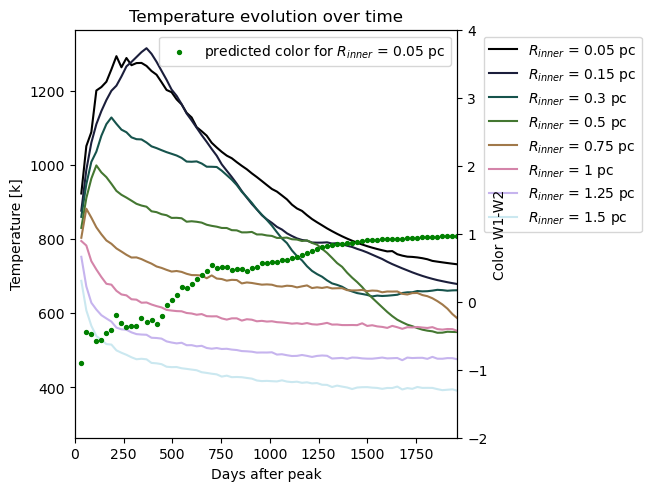

\begin{table}[H]
\centering
\begin{tabular}{c|c}
\hline
$R_{inner}$ pc & Average temperature [K] \\
\hline
0.05 & 867.0 \\
0.15 & 864.0 \\
0.3 & 806.0 \\
0.5 & 729.0 \\
0.75 & 651.0 \\
1.0 & 587.0 \\
1.25 & 504.0 \\
1.5 & 428.0 \\
\hline
\end{tabular}
\caption{The predicted average temperatures over a period of roughly 1900 days for $R_{inner}$ ranging between 0.05 and 1.5 pc.}
\label{$R_{inner}$_table}
\end{table}
0.05 1.5
Saving figure to thesis_plot/ASASSN-15lh/$R_{inner}$/


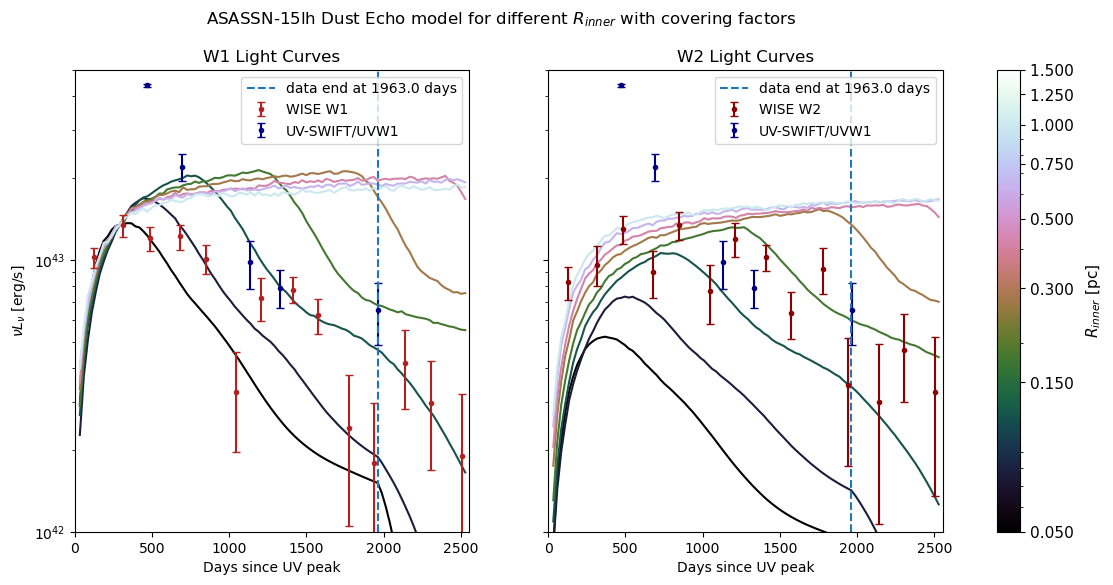

In [64]:

output_wavelengths_opt = np.sort(np.concatenate((np.linspace(0.01, 1, 20), np.linspace(1.01, 10, 800), \
                                              np.linspace(10.01, 50, 1000),w1w2,bbwl)))

loc_opt= '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1029/test/optical_depth/luminosities.txt'
#temperature_analysis_single(loc_opt,all_spectra = True ,output_wavelengths = output_wavelengths,
 #                          p0 = (900,1e29) , bounds=((200,1e25),(2000,1e36)) )

loc_tau = '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau' # old
loc_a = '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga' #old data
loc_r_l = '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_l/1112/ChangingR' #old 
loc_r_p = '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR' #old
loc_r_inner = '/net/vdesk/data2/schoof/SKIRT/results/ASASSN-15lh/2024-05-24_p/1100/ChangingR_inner' #new data
loc_multiplelayer='/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1029/test/optical_depth/config.txt'
tau = [20,23,26,29,32,35]

loc_graphite = '/net/vdesk/data2/schoof/SKIRT/results/ASASSN-15lh/2024-05-26_p/2103/ChangingAC' #new data

radius = [0.15,0.2,0.5,0.75,1.0,1.5,2.0,2.5]
radius_p = [3.0,3.5,4.0,4.5,5,7.5]
tot_R = radius + radius_p




r_inner = data_analysis(file_loc = loc_r_inner,color_map='cubehelix',parameter_variation = [0.05,0.15,0.3,0.50,0.75,1,1.25,1.5],unit ='pc', data_end = 99,parameter = "R_inner",set_par_name = r'$R_{inner}$')
#r_inner.spectra(save = True,thesis_plot=True)
r_inner.temperature(show_target =False,save = False,thesis_plot=True,table =True)
#r_inner.color_plot(show_target=True,save = True,thesis_plot=True)
r_inner.lightcurve(show_target =True,save = True,thesis_plot=True,)
#r_inner.lightcurve(show_target =False,save = True,thesis_plot=True,ymax=1e46)

graphite = data_analysis(loc_graphite,parameter = 'a_C',parameter_variation = [0.005,0.01,0.025,0.05,0.75,0.1,0.5,1.0,5.0,7.0],data_end =99,unit = r"$\mu m$",set_par_name = r'$a_{C}$')
#graphite.spectra(save = True,thesis_plot=True,fit =False)
#graphite.color_plot(show_target=True,save = True,thesis_plot=True)
#graphite.color_plot(show_target=False,save = True,thesis_plot=True)
#graphite.temperature(show_target=True,save = True,thesis_plot=True)
#graphite.lightcurve(sub_title = r' Dust echo model for different graphite grain sizes',show_target=False,save = True,thesis_plot=True,ymax=1e46 )
#graphite.lightcurve(sub_title = r' Dust echo model for different graphite grain sizes',show_target=True,save = True,thesis_plot=True, )


loc_thick ='/net/vdesk/data2/schoof/SKIRT/results/ASASSN-15lh/2024-05-26_p/2103/ChangingR' 
R_outer_var = [0.15,0.2,0.5,0.75,1.0,1.5,2.0,2.5,5]
thickness = data_analysis(file_loc = loc_thick,parameter_variation = R_outer_var,parameter='R', set_par_name ='thickness',unit= 'pc',data_end=99 )
#thickness.spectra(save = True,thesis_plot=True,fit =False)
#thickness.lightcurve(show_target=False,save = True,thesis_plot=True,ymax=1e46)
#thickness.lightcurve(show_target=True,save = True,thesis_plot=True,)
#thickness.temperature(show_target=False,save = True,thesis_plot=True)
#thickness.color_plot(show_target=False,save = True,thesis_plot=True)

loc_tau_new = '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-28_p/1158/ChangingTau'
opt_depths = [0.1,0.5,1,5,10,20,24,25,26,35,50,100]
tau = data_analysis(file_loc = loc_tau_new,parameter_variation = opt_depths,parameter = 'tau',set_par_name =r'$\tau$',data_end =99)
#tau.spectra(save = True,thesis_plot=True,fit =False)
#tau.lightcurve(show_target=False,save = True,thesis_plot=True,ymax=1e46)
#tau.lightcurve(show_target=True,save = True,thesis_plot=True,)
#tau.temperature(show_target=True,save = True,thesis_plot=True)
#tau.color_plot(show_target=True,save = True,thesis_plot=True)
#tau.color_plot(show_target=False,save = True,thesis_plot=True)

graphite_law_loc = '/net/vdesk/data2/schoof/SKIRT/results/ASASSN-15lh/2024-05-29_p/1051/ChangingGPLC'

graphite_power = data_analysis(graphite_law_loc,parameter_variation=[1.5,1.65,1.8,1.95,2.1,2.25,2.4,2.55,2.7,2.85,3.0],data_end = 99,
                              parameter = 'a_C' ,set_par_name= r'$\gamma_{C}$')
#graphite_power.spectra(save = True,thesis_plot=True,fit =False)
#graphite_power.lightcurve(show_target=False,save = True,thesis_plot=True,ymax=1e46)
#graphite_power.lightcurve(show_target=True,save = True,thesis_plot=True,)
#graphite_power.temperature(show_target=False,save = True,thesis_plot=True)
#graphite_power.color_plot(show_target=False,save = True,thesis_plot=True)
#graphite_power.temperature(show_target=True,save = True,thesis_plot=True)
#graphite_power.color_plot(show_target=True,save = True,thesis_plot=True)


# source code 

10/06/2024 15:57:13.116 ! <>:31: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:57:13.119 ! <>:31: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:57:13.122 ! /var/tmp/schoof/ipykernel_1883196/3364120281.py:31: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:57:13.122 !   a_si = data_analysis(a_si_loc,parameter_variation =[0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0],parameter ='a_Si',data_end = 99, set_par_name = r'$a_{Si}$',unit = '$\mu m$')


Saving figure to thesis_plot/ASASSN-15lh/Silicate fraction/without_target/


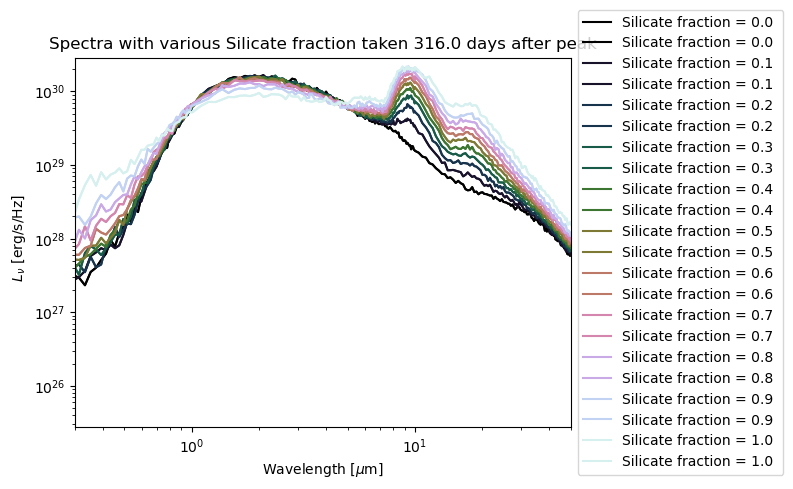

Saving figure to thesis_plot/ASASSN-15lh/Silicate fraction/without_target/


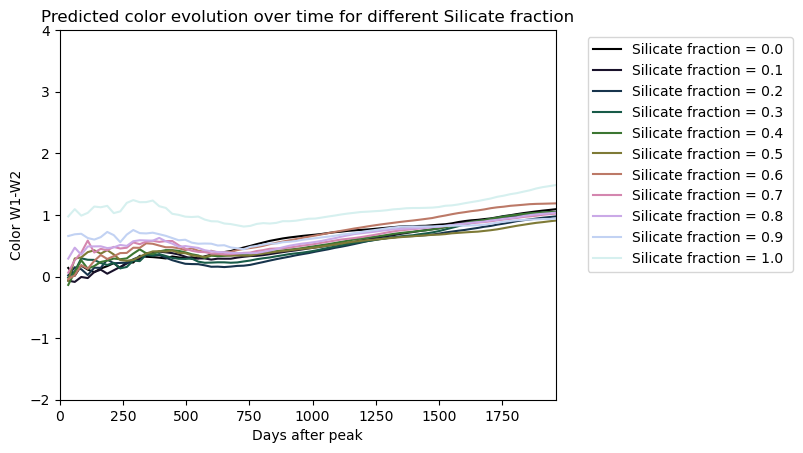

plotting color data from ASASSN-15lh


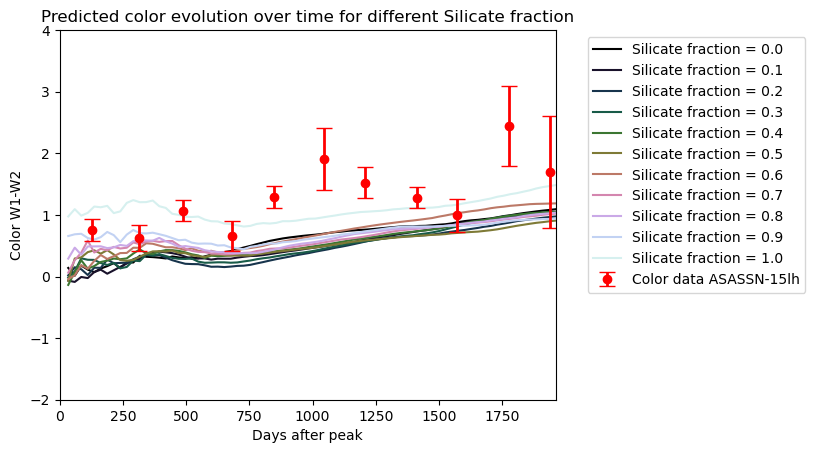

Saving figure to thesis_plot/ASASSN-15lh/$\alpha$/without_target/


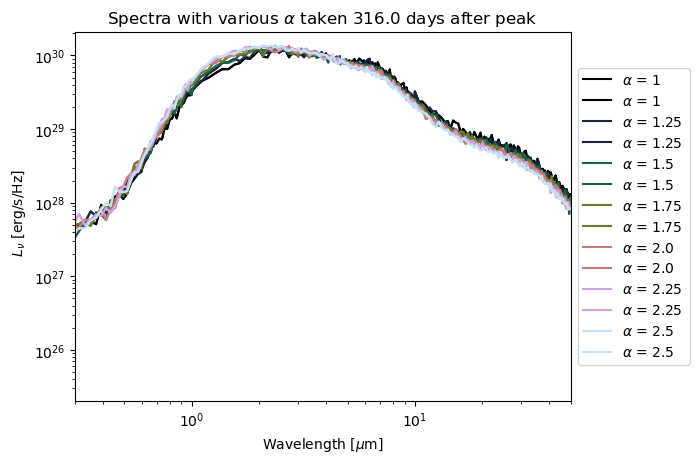

Saving figure to thesis_plot/ASASSN-15lh/$a_{Si}$/without_target/


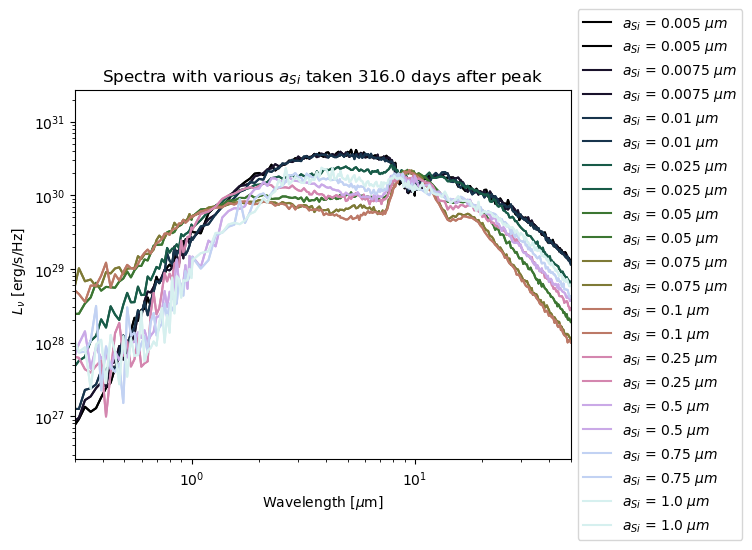

Saving figure to thesis_plot/ASASSN-15lh/$\gamma_{Si}$/without_target/


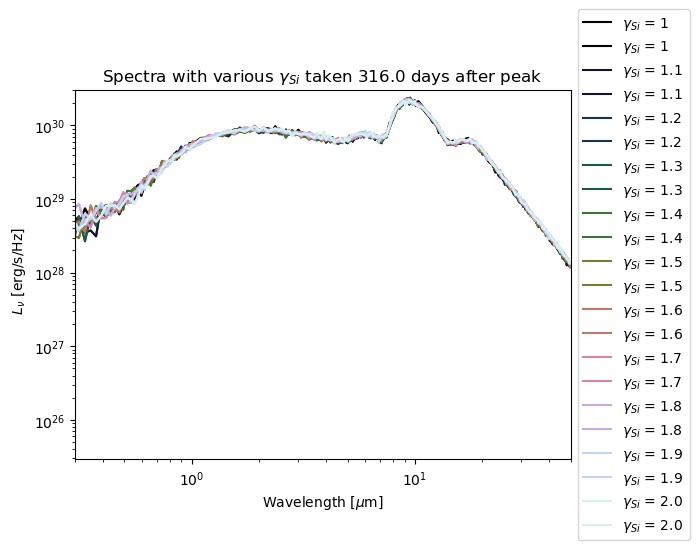

Saving figure to thesis_plot/ASASSN-15lh/Spectra_evolution/$R_{inner}$/


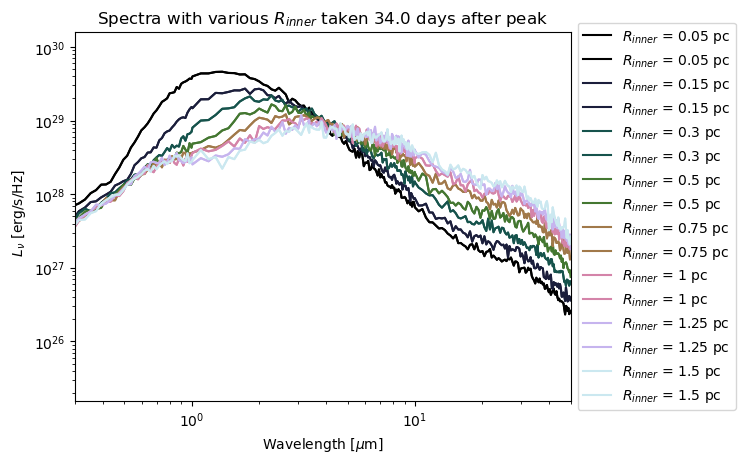

Saving figure to thesis_plot/ASASSN-15lh/Spectra_evolution/$a_{C}$/


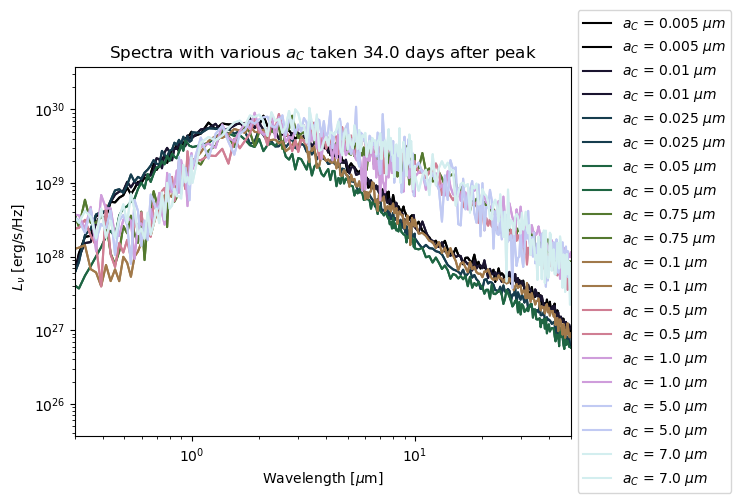

Saving figure to thesis_plot/ASASSN-15lh/Spectra_evolution/thickness/


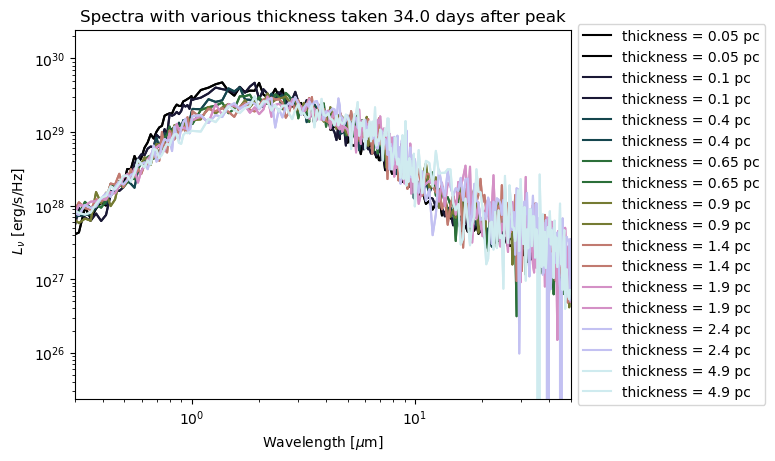

10/06/2024 15:57:26.649 ! /var/tmp/schoof/ipykernel_1883196/3364120281.py:31: SyntaxWarning: invalid escape sequence '\m'
10/06/2024 15:57:26.649 !   a_si = data_analysis(a_si_loc,parameter_variation =[0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0],parameter ='a_Si',data_end = 99, set_par_name = r'$a_{Si}$',unit = '$\mu m$')


AttributeError: 'list' object has no attribute 'spectra'

In [94]:
si_loc = '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi' 
si_par=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

si = data_analysis(si_loc,parameter_variation =si_par,parameter= 'Si', data_end = 99, set_par_name = 'Silicate fraction')
si.spectra(save = True,thesis_plot=True,fit =False)
#si.lightcurve(show_target=False,save = True,thesis_plot=True,ymax=1e46)
#si.lightcurve(show_target=True,save = True,thesis_plot=True,)
#si.temperature(show_target=False,save = True,thesis_plot=True)
si.color_plot(show_target=False,save = True,thesis_plot=True)
#si.temperature(show_target=True,save = True,thesis_plot=True)
si.color_plot(show_target=True,save = False,thesis_plot=True)





dens_loc = '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-25_p/2201/ChangingAlpha'
dens = data_analysis(dens_loc,parameter_variation = [1,1.25,1.5,1.75,2.0,2.25,2.5],data_end=99,parameter ='Alpha', set_par_name = r'$\alpha$' )
dens.spectra(save = True,thesis_plot=True,fit =False)
##dens.lightcurve(show_target=False,save = True,thesis_plot=True,ymax=1e46)
#dens.lightcurve(show_target=True,save = True,thesis_plot=True,)
#dens.temperature(show_target=False,save = True,thesis_plot=True)
#dens.color_plot(show_target=False,save = True,thesis_plot=True)
#dens.temperature(show_target=True,save = True,thesis_plot=True)
#dens.color_plot(show_target=True,save = True,thesis_plot=True)




a_si_loc = '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-26_p/2000/ChangingASi'
a_si = data_analysis(a_si_loc,parameter_variation =[0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0],parameter ='a_Si',data_end = 99, set_par_name = r'$a_{Si}$',unit = '$\mu m$')
a_si.spectra(save = True,thesis_plot=True,fit =False)
#a_si.lightcurve(show_target=False,save = True,thesis_plot=True,ymax=1e46)
#a_si.lightcurve(show_target=True,save = True,thesis_plot=True,)
#a_si.temperature(show_target=False,save = True,thesis_plot=True)
#a_si.color_plot(show_target=False,save = True,thesis_plot=True)
#a_si.temperature(show_target=True,save = True,thesis_plot=True)
#a_si.color_plot(show_target=True,save = True,thesis_plot=True)



gamma_loc = '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-28_p/2210/ChangingPowerLawSi'
gamma_si = data_analysis(gamma_loc, parameter_variation = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0],data_end = 99,parameter= 'GPL_Si',set_par_name = r'$\gamma_{Si}$')

gamma_si.spectra(save = True,thesis_plot=True,fit =False)
#gamma_si.lightcurve(show_target=False,save = True,thesis_plot=True,ymax=1e46)
#gamma_si.lightcurve(show_target=True,save = True,thesis_plot=True,)
#gamma_si.temperature(show_target=False,save = True,thesis_plot=True)
#gamma_si.color_plot(show_target=False,save = True,thesis_plot=True)
#gamma_si.temperature(show_target=True,save = True,thesis_plot=True)
#gamma_si.color_plot(show_target=True,save = True,thesis_plot=True)


for i in np.array([1,20,40,60,76]):
    
    r_inner.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =True,fit =False)
    graphite.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =True,fit =False)
    thickness.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =True,fit =False)
    tau.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =True,fit =False)
    graphite_power.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =Tru,fit =Falsee)
    si.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =True,fit =False)
    dens.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =True,fit =False)
    a_si.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =True,fit =False)
    gamma_si.spectra(save = True,thesis_plot=True,time =i,spectra_evolution =True,fit =False)
    
    




03/06/2024 13:32:41.460 ! <>:12: SyntaxWarning: invalid escape sequence '\m'
03/06/2024 13:32:41.462 ! <>:12: SyntaxWarning: invalid escape sequence '\m'
03/06/2024 13:32:41.463 ! /var/tmp/schoof/ipykernel_1883196/2413516320.py:12: SyntaxWarning: invalid escape sequence '\m'
03/06/2024 13:32:41.463 !   axs[row, col].set_xlabel('Wavelength [$\mu$m]')


Saving figure to thesis_plot/ASASSN-15lh/$R_{inner}$/without_target/


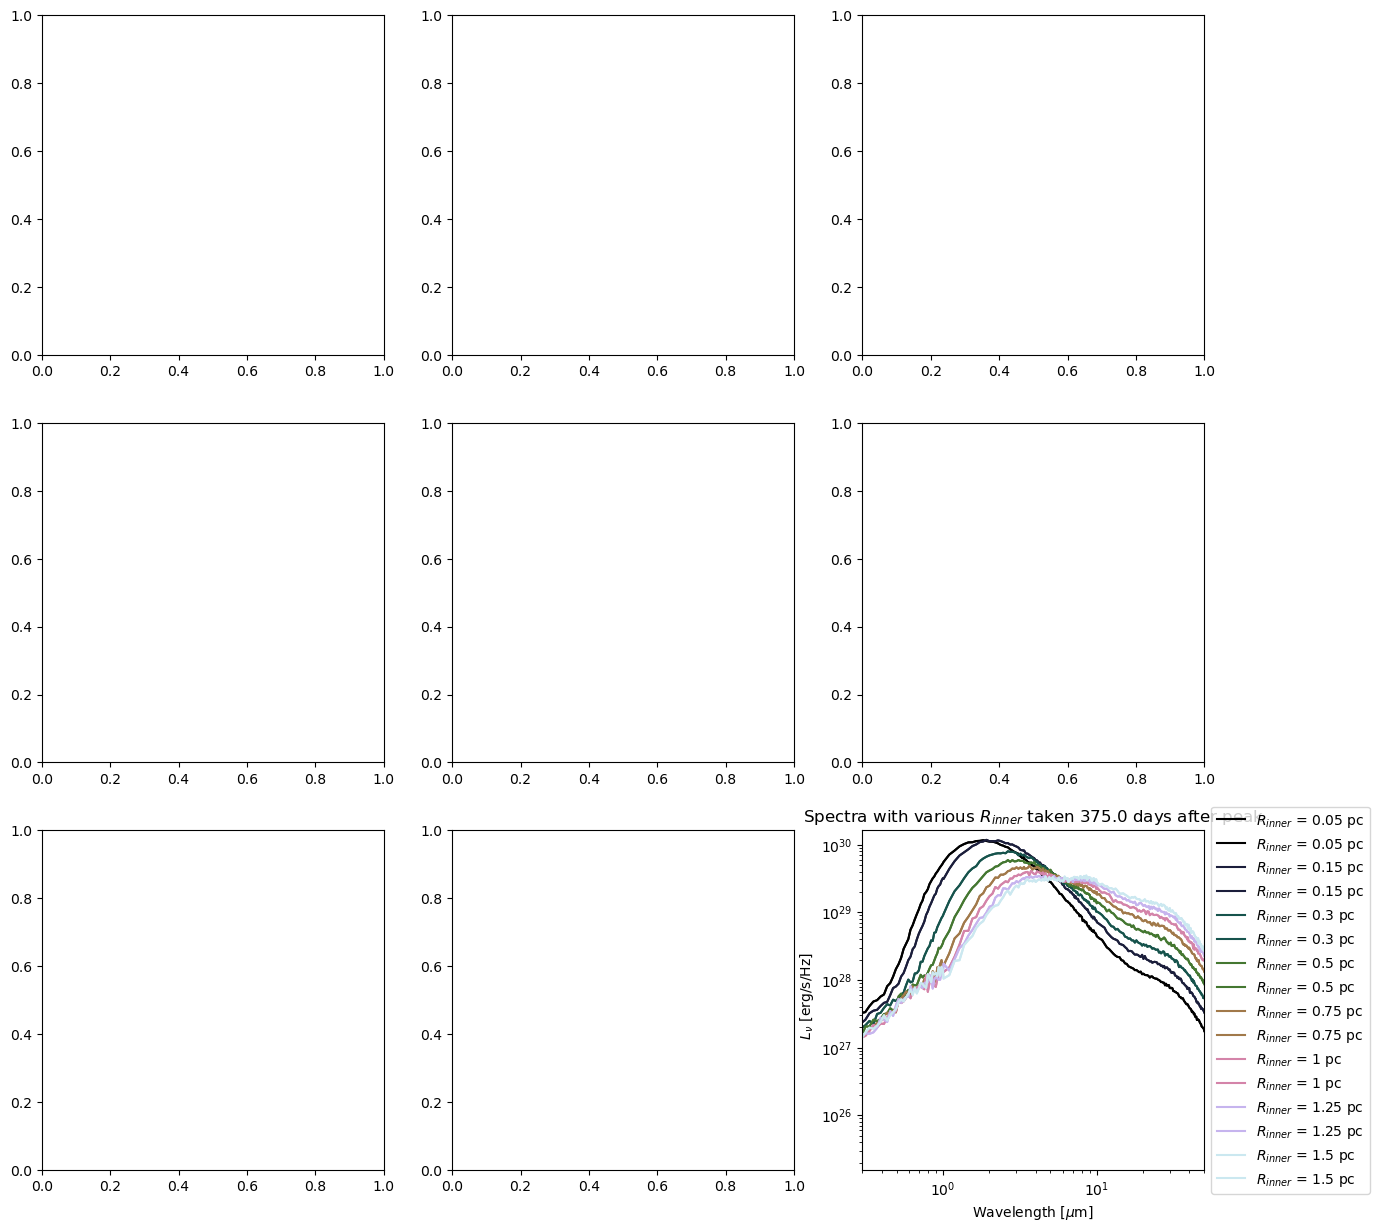

03/06/2024 13:32:44.135 ! /var/tmp/schoof/ipykernel_1883196/2413516320.py:12: SyntaxWarning: invalid escape sequence '\m'
03/06/2024 13:32:44.135 !   axs[row, col].set_xlabel('Wavelength [$\mu$m]')


TypeError: float() argument must be a string or a real number, not 'Line2D'

In [51]:

par_list = [r_inner,thickness,tau,graphite,graphite_power,si,dens,a_si,gamma_si]


fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for idx, variable in enumerate(par_list):
    lines = variable.spectra(save=True, thesis_plot=True, fit=False,multi_plot =True)
    row = idx // 3
    col = idx % 3
    for line in lines:
        axs[row, col].plot(line)
    axs[row, col].set_xlabel('Wavelength [$\mu$m]')
    axs[row, col].set_ylabel(r'$L_{\nu}$ [erg/s/Hz]')
    axs[row, col].legend()
    axs[row, col].set_title(f'{variable.parameter} Spectra')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


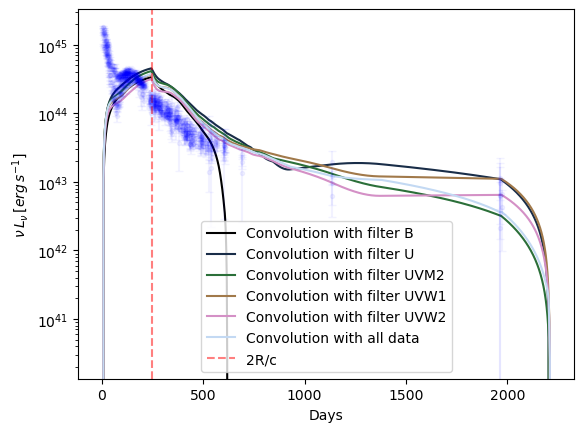

In [54]:
distance = 1171*u.Mpc
_, filters, SWIFT_freq, mjd0 = get_lightcurve_data() 
lightcurve = True

def select_filter_data(L, filter_values):
    selected_data = {}
    for i, filter_val in enumerate(filter_values, start=1):
        filter_indices = np.argwhere(np.isclose(L[3], filter_val)).flatten()
        time_range = np.squeeze(L[0][filter_indices])
        light = np.squeeze(L[1][filter_indices])
        error = np.squeeze(L[2][filter_indices])
        selected_data[i] = {'time_range': time_range, 'light': light, 'error': error}
    return selected_data

#Only selecting data from certain filters
selected_data = select_filter_data(L, np.unique(L[3]))
data = selected_data[1]

time_range, light, error = data['time_range'], data['light'], data['error']
def convolution(rinner_pc,flux_pick,mjd_pick):
    """
     Makes a convolution of a step function with length 2r/c and value c/(2r) with the luminosity data.
     Returns the time and flux of this convolution.
     Parameters
     ----------
     rinner_pc : float
          The outer radius of the dust shell.
     flux_pick: array
          Array containing the flux of the original source. 
     mjd_pick: array 
          Time in MjD.
    """
    rinner_days = ((rinner_pc*u.pc / c.c ).to(u.day)).value
    
    transfunc_time = np.arange(0,2*rinner_days+100, 0.5)
    transfunc_amp = np.zeros(len(transfunc_time))
    transfunc_amp[transfunc_time<2*rinner_days]= 1/ (2*rinner_days)

    # padding with zeros
    flux_pick = np.append(0, flux_pick)
    flux_pick = np.append(flux_pick, 0)

    mjd_pick = np.append(mjd_pick[0]-1,mjd_pick)
    mjd_pick = np.append(mjd_pick, mjd_pick[-1]+1)
    
    # define output times for convolved function
    lc_conv_time = np.arange(mjd_pick[0]-10,mjd_pick[-1]+2*rinner_days+10, 2)  # grid with 2 day steps
    lc_conv_flux = np.zeros(len(lc_conv_time))

    # loop and find the flux of the light curve that contributes 
    for i, ctime in enumerate(lc_conv_time):
        flux_before = np.interp(ctime-transfunc_time, mjd_pick, flux_pick) # we look "back in time"
        lc_conv_flux[i] = np.trapz(flux_before*transfunc_amp, transfunc_time) # the tranfer function is normalized
    return lc_conv_time, lc_conv_flux

#Plotting the convolutions
cmap = plt.get_cmap('cubehelix')
for j in range(6):
    color = cmap(j/6) #Get the color from the colormap
    if j == 5:
        lc_conv_time,lc_conv_flux = convolution(centralBin,L[1][sorted_indices],L[0][sorted_indices])
        plt.plot(lc_conv_time,lc_conv_flux,label = 'Convolution with all data',color=color) 
    else:
        data = selected_data[j+1]
        time_range, light= data['time_range'], data['light']
        lc_conv_time,lc_conv_flux = convolution(centralBin,light,time_range)
        plt.plot(lc_conv_time,lc_conv_flux,label = f'Convolution with filter {filters[j].replace(".uvot","")}',color=color)

rinner_days = ((centralBin*u.pc / c.c ).to(u.day)).value


plt.errorbar(L[0],L[1], yerr=L[2], fmt='.', alpha=0.05, capsize=3, color = 'blue')
plt.yscale('log')
plt.axvline(x= L[0][sorted_indices[0]]+ 2* rinner_days,linestyle = '--', label = "2R/c", alpha = 0.5, color = 'red')
plt.legend()
plt.xlabel('Days')
plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$")
plt.show()

30/05/2024 13:12:36.405 ! /usr/lib64/python3.12/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
30/05/2024 13:12:36.405 !   return _methods._mean(a, axis=axis, dtype=dtype,
30/05/2024 13:12:36.406 ! /usr/lib64/python3.12/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
30/05/2024 13:12:36.406 !   ret = ret.dtype.type(ret / rcount)
30/05/2024 13:12:36.406 ! /usr/lib64/python3.12/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
30/05/2024 13:12:36.406 !   ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
30/05/2024 13:12:36.406 ! /usr/lib64/python3.12/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
30/05/2024 13:12:36.406 !   arrmean = um.true_divide(arrmean, div, out=arrmean,
30/05/2024 13:12:36.407 ! /usr/lib64/python3.12/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered 

0.05 1.5
Saving figure to thesis_plot/ASASSN-15lh/$R_{inner}$/


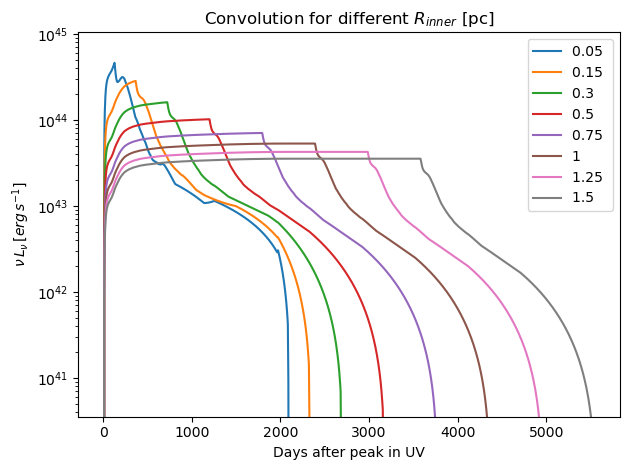

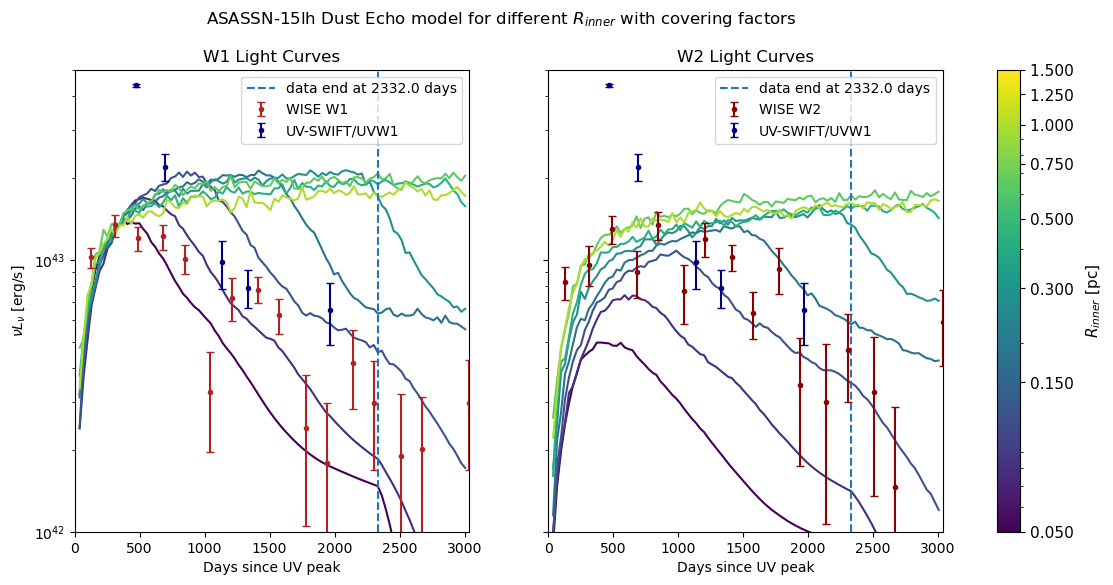

<Figure size 640x480 with 0 Axes>

In [57]:
mask = L[0] > 0
L_filtered = L[:, mask]
sorted_indices = L_filtered[0].argsort()


# Plotting for each of the separate filters

# Plotting for all filters
for i in [0.05,0.15,0.3,0.50,0.75,1,1.25,1.5]:
    lc_conv_time,lc_conv_lum = convolution(i,L_filtered[1][sorted_indices],L_filtered[0][sorted_indices])
    plt.plot(lc_conv_time,lc_conv_lum,label = f'{i} ',)#color=cmap(i+1/(len(filters)+1))) 
plt.title(r"Convolution for different $R_{inner}$ [pc]")

plt.yscale('log')
plt.ylim(np.max(lc_conv_lum)/1e3)
#plt.axvline(x= L[0][sorted_indices[0]]+ 2* rinner_days,linestyle = '--', label = "2R/c", alpha = 0.5, color = 'red')
plt.xlabel('Days after peak in UV')
plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$")
plt.legend()
plt.tight_layout()
r_inner.lightcurve(show_target =True,save = True,thesis_plot=True,)
plt.savefig(OUTFILES+target+"_convolutions.pdf")
plt.show()


